In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import functools
import torchvision.models as models
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage import io, transform
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [ ]:
torchvision.__version__

'0.16.0+cu121'

In [ ]:
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 4,5,6,7'

In [ ]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/train5000/'
VAL_DIR = '/content/drive/MyDrive/validate5000/'

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset  # Import the Dataset class
from PIL import Image

class ImagePairDataset(Dataset):
    """A dataset class for paired image dataset."""

    def __init__(self, sketch_dir, photo_dir, transform=None):
        """
        Args:
            sketch_dir (string): Directory with all the sketch images.
            photo_dir (string): Directory with all the corresponding photos.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.transform = transform

        # Assuming the sketches are named as '1_sketch.png', '2_sketch.png', ...
        self.sketches = [f"{i}_sketch.png" for i in range(1, 4999)]
        self.photos = [f"{i}.png" for i in range(1, 4999)]

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketches[idx])
        photo_path = os.path.join(self.photo_dir, self.photos[idx])

        sketch = Image.open(sketch_path).convert('RGB')
        photo = Image.open(photo_path).convert('RGB')

        if self.transform:
            sketch, photo = self.transform(sketch, photo)

        return sketch, photo

class Train_Normalize(object):
    def __call__(self, sketch, photo):
        sketch = np.array(sketch).astype(np.float32)
        photo = np.array(photo).astype(np.float32)

        # Apply random jittering and mirroring here if necessary
        # For simplicity, the function is not included in this example
        # sketch, photo = random_jittering_mirroring(sketch, photo)

        # Normalize the images
        sketch = (sketch / 127.5) - 1
        photo = (photo / 127.5) - 1

        # Convert to PyTorch tensors
        sketch_tensor = torch.from_numpy(sketch.transpose((2, 0, 1)))
        photo_tensor = torch.from_numpy(photo.transpose((2, 0, 1)))

        return sketch_tensor, photo_tensor

class Val_Normalize(object):
    def __call__(self, sketch, photo):
        sketch = np.array(sketch).astype(np.float32)
        photo = np.array(photo).astype(np.float32)

        # Normalize the images
        sketch = (sketch / 127.5) - 1
        photo = (photo / 127.5) - 1

        # Convert to PyTorch tensors
        sketch_tensor = torch.from_numpy(sketch.transpose((2, 0, 1)))
        photo_tensor = torch.from_numpy(photo.transpose((2, 0, 1)))

        return sketch_tensor, photo_tensor

In [ ]:
train_sketch_dir = '/content/drive/MyDrive/train5000/sketches'
train_photo_dir = '/content/drive/MyDrive/train5000/images'
val_sketch_dir = '/content/drive/MyDrive/validate5000x/sketches'
val_photo_dir = '/content/drive/MyDrive/validate5000x/images'

# Initialize the custom dataset with the new directories
train_ds = ImagePairDataset(train_sketch_dir, train_photo_dir, transform=Train_Normalize())
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = ImagePairDataset(val_sketch_dir, val_photo_dir, transform=Val_Normalize())
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [ ]:
#VAL_DIR = '/content/drive/MyDrive/validate5000/'

#batch_size = 16 * n_gpus

#val_ds = ImageFolder(VAL_DIR, transform=transforms.Compose([
 #       Val_Normalize()]))
#val_dl = DataLoader(val_ds, batch_size)

In [ ]:

VAL_DIR

'/content/drive/MyDrive/validate5000/'

In [ ]:
import matplotlib.pyplot as plt

def imshow(inputs, target, figsize=(10, 5)):
    inputs = inputs.numpy().transpose((1, 2, 0))
    target = target.numpy().transpose((1, 2, 0))
    inputs = (inputs * 0.5) + 0.5  # unnormalize
    target = (target * 0.5) + 0.5  # unnormalize

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(inputs)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(target)
    plt.title('Target Image')
    plt.axis('off')

    plt.show()

def show_batch(dl):
    for images in dl:
        sketch, photo = images
        imshow(sketch[0], photo[0])  # Show first pair in the batch
        break  # Only show one batch


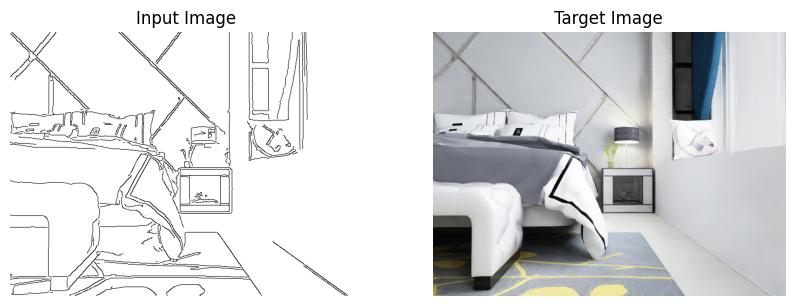

In [ ]:
show_batch(train_dl)

In [ ]:
# custom weights initialization called on generator and discriminator
def weights_init(net, init_type='normal', scaling=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


In [ ]:
def get_norm_layer():
    """Return a normalization layer
       For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    """
    norm_type = 'batch'
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    return norm_layer

In [ ]:
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()

        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)

        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)

        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)

        # Outermost layer with output_nc as the final number of channels
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

        # Additional module to adjust the number of channels if needed
        self.adjust_channels = AdjustChannels(input_nc, output_nc)

    def forward(self, input):
        # Forward pass through the generator
        model_output = self.model(input)
        return model_output

class AdjustChannels(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AdjustChannels, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1 convolution

    def forward(self, x):
        return self.conv(x)



In [ ]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            # Get the output from the submodule
            output = self.model(x)

            # Crop 'x' to match the size of 'output', if necessary
            _, _, h, w = output.size()
            x_cropped = x[:, :, :h, :w]

            # Concatenate along the channel dimension
            return torch.cat([x_cropped, output], 1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.device_count()

1

In [ ]:
norm_layer = get_norm_layer()

In [ ]:
generator = UnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False)#.cuda().float()
generator.apply(weights_init)

generator = torch.nn.DataParallel(generator)  # multi-GPUs

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initiali

In [ ]:
#generator

In [ ]:
inp = torch.ones(1, 3,256,256)
#gen = generator(inp)
device = 'cuda'
inp = inp.to(device)
generator = generator.to(device)

In [ ]:
print(summary(generator,(3,256,256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [ ]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [ ]:
discriminator = Discriminator(6, 64, n_layers=3, norm_layer=norm_layer)#.cuda().float()
discriminator.apply(weights_init)
discriminator = torch.nn.DataParallel(discriminator)  # multi-GPUs

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [ ]:
inp = torch.ones(1,6,256,256)
disc = discriminator(inp)
# device = 'cuda'
# inp = inp.to(device)
# discriminator = discriminator.to(device)

In [ ]:
summary(discriminator,(6,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
          Sigmoid-13            [-1, 1, 30, 30]               0
    Discriminator-14            [-1, 1,

In [ ]:
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

In [ ]:
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    #print(gen_loss)
    return gen_total_loss

In [ ]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [ ]:
learning_rate = 2e-4
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))


In [ ]:
save_dir = 'torch/training_weights'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
torch.save(generator.state_dict(), f'{save_dir}/generator_epoch_.pth')
torch.save(discriminator.state_dict(), f'{save_dir}/discriminator_epoch_.pth')

In [ ]:
num_epochs = 2
D_loss_plot, G_loss_plot = [], []

for epoch in range(1, num_epochs + 1):
    D_loss_list, G_loss_list = [], []

    for sketches, photos in train_dl:
        sketches = sketches.to(device)
        photos = photos.to(device)

    # Generate fake photos
        fake_photos = generator(sketches)

    # Resize fake_photos to match the size of sketches
        fake_photos_resized = F.interpolate(fake_photos, size=(sketches.size(2), sketches.size(3)), mode='bilinear', align_corners=False)

        disc_input_fake = torch.cat((sketches, fake_photos_resized), 1)
        disc_input_real = torch.cat((sketches, photos), 1)

        D_fake = discriminator(disc_input_fake.detach())
        D_real = discriminator(disc_input_real)

        # Calculate loss for fake and real
        real_target = torch.ones(D_real.size()).to(device)
        fake_target = torch.zeros(D_fake.size()).to(device)

        D_real_loss = adversarial_loss(D_real, real_target)
        D_fake_loss = adversarial_loss(D_fake, fake_target)
        D_total_loss = (D_real_loss + D_fake_loss) / 2

        D_total_loss.backward()
        D_optimizer.step()

        # Train generator
        G_optimizer.zero_grad()

        # Get discriminator evaluation of the fake photo
        G_fake = discriminator(disc_input_fake)
        G_loss = generator_loss(fake_photos_resized, photos, G_fake, real_target)

        G_loss.backward()
        G_optimizer.step()

        # Store losses for plotting
        D_loss_list.append(D_total_loss.item())
        G_loss_list.append(G_loss.item())

    # Print progress
        print(f'Epoch [{epoch}/{num_epochs}], D Loss: {np.mean(D_loss_list):.4f}, G Loss: {np.mean(G_loss_list):.4f}')

    # Save model checkpoints
    torch.save(generator.state_dict(), f'generator_epoch_{epoch}.pth')
    torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch}.pth')

Epoch [1/2], D Loss: 0.8410, G Loss: 47.1773
Epoch [1/2], D Loss: 1.1040, G Loss: 43.1895
Epoch [1/2], D Loss: 1.0340, G Loss: 42.9632
Epoch [1/2], D Loss: 1.1078, G Loss: 42.7243
Epoch [1/2], D Loss: 1.1430, G Loss: 41.9424
Epoch [1/2], D Loss: 1.2048, G Loss: 41.3921
Epoch [1/2], D Loss: 1.2567, G Loss: 40.3715
Epoch [1/2], D Loss: 1.3602, G Loss: 40.2482
Epoch [1/2], D Loss: 1.6115, G Loss: 39.5892
Epoch [1/2], D Loss: 1.8138, G Loss: 39.6480
Epoch [1/2], D Loss: 1.8992, G Loss: 39.9182
Epoch [1/2], D Loss: 1.9332, G Loss: 40.1946
Epoch [1/2], D Loss: 1.9440, G Loss: 40.4353
Epoch [1/2], D Loss: 1.9466, G Loss: 40.7478
Epoch [1/2], D Loss: 1.9406, G Loss: 40.7431
Epoch [1/2], D Loss: 1.9259, G Loss: 40.5008
Epoch [1/2], D Loss: 1.8988, G Loss: 40.1626
Epoch [1/2], D Loss: 1.8569, G Loss: 39.9795
Epoch [1/2], D Loss: 1.8134, G Loss: 39.8164
Epoch [1/2], D Loss: 1.7686, G Loss: 39.7113
Epoch [1/2], D Loss: 1.7257, G Loss: 40.2618
Epoch [1/2], D Loss: 1.6882, G Loss: 40.0156
Epoch [1/2

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/train5000/sketches/29_sketch.png'